Goal : explore the lyrics data, and make a simple model to predict the genras based on the lyrics

# 1. Import and path configuration part

In [1]:
import sys, os
sys.path.append(os.getcwd())
datapath = "../data/msdi/"
os.chdir(datapath)
!ls

README.md      img	   lyrics	      mfcc
deep_features  labels.csv  metadata_msdi.csv  msdi_mapping.csv


In [2]:
import numpy as np
import matplotlib as plt
import torch

from sam_utils import *
from models import *
from utils import *

In [3]:
msdi = get_msdi_dataframe("")
msdi.head(2)

,Unnamed: 0,msd_track_id,genre,album_index,set,msd_artist_id,image_url,img,mfcc,deep_features
0,0,TRABKJU128F422A7FE,Metal,0,train,ARBD4QW1187FB42153,http://artwork-cdn.7static.com/static/img/slee...,img/0000848744_200.jpg,mfcc/mfcc_A.npz,0
1,1,TRBLDQQ128F92E58B4,Rock,1,train,AR3RK011187FB3CE3B,http://artwork-cdn.7static.com/static/img/slee...,img/0000476534_200.jpg,mfcc/mfcc_B.npz,1


# 2. Data exploration

In [4]:
print(len(msdi), len(os.listdir("lyrics"))) # we dont have the lyrics for each data (can be problematic for the multimodal part)

30712 14750


In [5]:
# load all the lyrics data
data = {}
for elem in os.listdir("lyrics"):
    data[elem[:-5]] = pd.read_json("lyrics/" + elem, typ="series")

min = 2 max= 1739 mean= 236.44020338983051


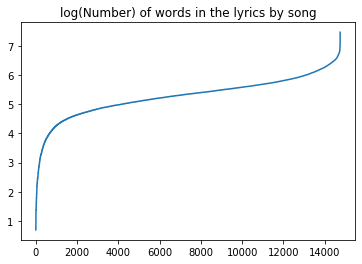

In [15]:
# Total wordcount of the words that appear in each song

total_wordcount = []
for k in data.keys():
    total_wordcount.append(data[k].sum())
    
total_wordcount.sort()

plt.plot(np.log(total_wordcount))
plt.title("log(Number) of words in the lyrics by song")

print("min =",min(total_wordcount),"max=", max(total_wordcount), "mean=", np.mean(total_wordcount))

# there is a lot of variance in the number of words with have in the lyrics
# do we need to filter out some lyrics ?

min = 1 max= 428 mean= 86.86447457627119


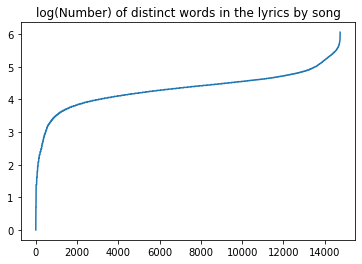

In [16]:
# Number of distinct words in each song

word_number = []

for k in data.keys():
    word_number.append(len(data[k]))
    
word_number.sort()

plt.plot(np.log(word_number))
plt.title("log(Number) of distinct words in the lyrics by song")

print("min =",min(word_number),"max=", max(word_number), "mean=", np.mean(word_number))

# 3. Training a classifier

In [6]:
torch.cuda.is_available()

True

In [7]:
# set embedding parameters, and load model on gpu
max_len = 500
batch_size = 64
embed_size = 128
hidden_size = 128
genras = 15
model = lyrics_model(max_len, embed_size,hidden_size, genras)
device = torch.device('cuda') 
model.to(device)

lyrics_model(
  (embed): Embedding(500, 128)
  (seen_words_rnn): GRU(128, 128, batch_first=True)
  (words_frequency_rnn): GRU(128, 128, batch_first=True)
  (seen_words_dropout): Dropout(p=0.3, inplace=False)
  (words_frequency_dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=256, out_features=15, bias=True)
)

## 1. Data formatting

In [8]:
X,Y,Y_dict = format_data_lyrics(data, max_len, msdi)


In [9]:
X = torch.from_numpy(X)
Y = torch.LongTensor(Y)

print(X.size())
print(Y.size())

torch.Size([14750, 1000])
torch.Size([14750])


In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size(),X_test.size())
print(Y_train.size(),Y_test.size())

torch.Size([10325, 1000]) torch.Size([4425, 1000])
torch.Size([10325]) torch.Size([4425])


In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

In [59]:
import torch.nn as nn
from torch import optim

### training/perf/predict functions

def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
        with torch.no_grad():
            x_seen_words = x[:,:max_len] 
            x_words_frequency = x[:,max_len:]
            y_scores = model(x_seen_words,x_words_frequency)
            loss = criterion(y_scores, y)
            y_pred = torch.max(y_scores, 1)[1]
            correct += torch.sum(y_pred.data == y)
            total_loss += loss.item()
            num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            seenwords, wordfreq = x[:,:max_len] ,x[:,max_len:]
            y_scores = model(seenwords.to(device), wordfreq.to(device))
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

def predict(model,loader):
    output = []
    for x, y in loader:
        with torch.no_grad():
            x_seen_words = x[:, :max_len]
            x_words_frequency = x[:, :max_len]
            y_scores = self(x_seen_words, x_words_frequency)
            y_pred = y_scores > 0.5
            output.append(y_pred.int())
    return output


In [60]:
fit(model, epochs=10)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR